In [8]:
import tensorflow as tf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

### Build the model

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [18]:
# Define the custom layers and model

class MyLayer(Layer):
    
    def __init__(self, units):
        super(MyLayer, self).__init__()
        self.units = units
    
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 name='kernel')
        self.b = self.add_weight(shape=(self.units, ),
                                initializer='zeros',
                                name = 'bias')
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [19]:
class MyDropout(Layer):
    
    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)

In [20]:
class MyModel(Model):
    
    def __init__(self, units_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3)
        self.softmax = Softmax()
        
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        return self.softmax(x)

In [21]:
# Instantiate the model object

model = MyModel(64, 64, 46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[0.03256642 0.01224306 0.0202058  0.01061631 0.04772274 0.01548778
  0.04976397 0.00833883 0.02743253 0.01094027 0.03035993 0.00661747
  0.01096503 0.02792487 0.01122196 0.01369515 0.08264106 0.01365957
  0.01791359 0.02241425 0.02188552 0.01092156 0.0122622  0.00297575
  0.01799752 0.0161662  0.04346247 0.02477277 0.02014047 0.00352731
  0.01609143 0.04606457 0.00987643 0.03677776 0.02450324 0.0160555
  0.01721312 0.00610849 0.03009802 0.0056685  0.03397263 0.01283165
  0.01659891 0.02429337 0.01299671 0.04400735]], shape=(1, 46), dtype=float32)
Model: "my_model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_6 (MyLayer)         multiple                  640064    
_________________________________________________________________
my_dropout_4 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_7 (MyLayer

### Load the reuters dataset and define the class_names

In [22]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

2113536/2110848 [==============================] - 0s 0us/step


/home/mach1ne/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/mach1ne/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [23]:
# Print the class of the first sample

print('Label: {}'.format(class_names[train_labels[0]]))

Label: earn


### Get the dataset word index

In [25]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

inver_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([inver_word_index.get(i-3, '?') for i in train_data[0]])

In [26]:
# Print the first data example sentence
print(text_news)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


### Preprocess the data

In [27]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print('Shape of x_train: ', x_train.shape)
print('Shape of x_test: ', x_test.shape)

Shape of x_train:  (8982, 10000)
Shape of x_test:  (2246, 10000)


### Define the loss function

In [33]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

### Train the model

In [34]:
# define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [37]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 10
weight_decay = 0.005

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    # Training loop
    for x, y in train_dataset:
        # optimizer the model
        loss_value, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # Compute the current loss
        epoch_loss_avg(loss_value)
        # Compare the predicted label to actual label
        epoch_accuracy(to_categorical(y), model(x))
        
    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                               epoch_loss_avg.result(),
                                                               epoch_accuracy.result()))

print('Duration : {:3f}'.format(time.time() - start_time))

Epoch 000: Loss: 1.752, Accuracy: 69.194%
Epoch 001: Loss: 1.734, Accuracy: 69.817%
Epoch 002: Loss: 1.728, Accuracy: 69.973%
Epoch 003: Loss: 1.715, Accuracy: 70.485%
Epoch 004: Loss: 1.707, Accuracy: 70.786%
Epoch 005: Loss: 1.716, Accuracy: 71.254%
Epoch 006: Loss: 1.697, Accuracy: 71.231%
Epoch 007: Loss: 1.688, Accuracy: 71.042%
Epoch 008: Loss: 1.683, Accuracy: 71.699%
Epoch 009: Loss: 1.691, Accuracy: 71.131%
Duration : 50.008852


### Evaluate the model

In [38]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [39]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [40]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    #optimize the model
    loss_value = loss(model, x, y, weight_decay)
    #Compute the current loss
    epoch_loss_avg(loss_value)
    # Compare predicted label to the actual label
    epoch_accuracy(to_categorical(y), model(x))

print('Test loss: {:.3f}'.format(epoch_loss_avg.result().numpy()))
print('Test accuracy: {:.3%}'.format(epoch_accuracy.result().numpy()))

Test loss: 1.834
Test accuracy: 68.032%


### Plot the learning curves

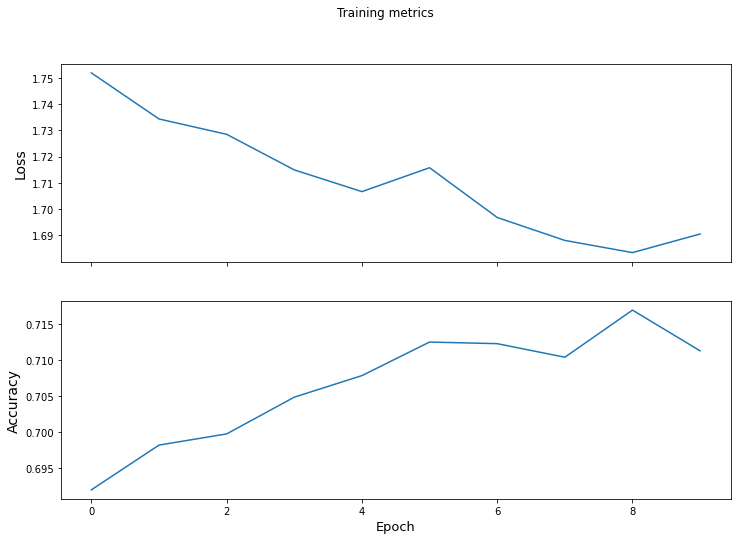

In [43]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=13)
axes[1].plot(train_accuracy_results)
plt.show()

### Predict from the model

In [44]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("Label: {}".format(class_names[train_labels[0]]))

Prediction: earn
Label: earn
